In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, brier_score_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, f1_score, log_loss, average_precision_score

from statistics import mode
from pandas import Series
from sklearn.model_selection import GridSearchCV
import pandas_profiling
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_columns', None)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# create requirments file
!pip freeze > requirments.txt

# fix seeds
RANDOM_SEED = 42

#### Functions

In [3]:
# calculating scores function
def scores(y_test, y_pred, prob):
    fpr, tpr, threshold = roc_curve(y_test, prob)
    roc_auc = roc_auc_score(y_test, prob)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    print ("f1_score:",round(f1_score(y_test,y_pred), 3))
    print ("accuracy_score:",round(accuracy_score(y_test,y_pred), 3))
    print ("precision_score:",round(precision_score(y_test,y_pred), 3))
    print ("recall_score:",round(recall_score(y_test,y_pred), 3))
    print ("log_loss:",round(log_loss(y_test,y_pred), 3))
    print ("roc_auc_score:",round(roc_auc, 3))
    print("average_precision_score:", round(average_precision_score(y_test,y_pred), 3))
    print("brier_score_loss:", round(brier_score_loss(y_test,y_pred), 3))
    print('Confusion matrix:\n{}' .format(confusion_matrix(y_test,y_pred)))

In [4]:
# check IQR
def iqr(dt, cl, pr=None):
    IQR = dt.loc[:, cl].quantile(0.75) - dt.loc[:, cl].quantile(0.25)
    perc25 = dt.loc[:, cl].quantile(0.25)
    perc75 = dt.loc[:, cl].quantile(0.75)
    lb = perc25 - 1.5*IQR
    hb = perc75 + 1.5*IQR

    if pd.isnull(pr):
        return [IQR, perc25, perc75, lb, hb, dt.loc[:, cl].max(), dt.loc[:, cl].min(), cl]
    else:
        print(cl,
              '25-й перцентиль: {},'.format(perc25),
              '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR),
              "Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))

In [5]:
# plot different types of standartization
# Compare initial data with standartized using StandardScaler, MinMaxScaler & logged
def select_norm(col):
    plt.figure()
    sns.histplot(data[col])
    plt.title('Initial')
    plt.show()
    
    plt.figure()
    sns.histplot(StandardScaler().fit_transform(data[col].values.reshape(-1, 1)))
    plt.title('Standartized')
    plt.show()
    
    plt.figure()
    sns.histplot(MinMaxScaler().fit_transform(data[col].values.reshape(-1, 1)))
    plt.title('MinMaxScaler')
    plt.show()
    
    plt.figure()
    sns.histplot(np.log(data[col]+1))
    plt.title('Logged')
    plt.show()

In [6]:
# plot one hist to check outliers closer or just to look deeper

# b - number of bins
# tit - hist title
# rhb - reviewed highest border in 'Здравый смысл'
# rlb - reviewed lowest border in 'Здравый смысл'
# one of rhb or rlb could be missed

def hist_check(dth, tit, b= 17, rhb=None, rlb=None):
    IQR = dth.quantile(0.75) - dth.quantile(0.25)
    perc25 = dth.quantile(0.25)
    perc75 = dth.quantile(0.75)
    lb = perc25 - 1.5*IQR
    hb = perc75 + 1.5*IQR

    print(
        '25-й перцентиль: {},'.format(perc25),
        'median: {},'.format(dth.quantile(0.5)),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))
    
    print("max value = {mx}\nmin value = {mn}\n".format(mx = max(dth),mn = min(dth)))

    fig = plt.figure()
    dth.loc[dth.between(
        lb,
        hb)].hist(bins=b, label='IQR')

    if rlb != None and rhb != None:
        dth.loc[(rlb <= dth) & (dth <= rhb)].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')
    elif pd.isnull(rlb) and rhb != None:
        dth.loc[dth <= rhb].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')
    elif pd.isnull(rhb) and rlb != None:
        dth.loc[rlb <= dth].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')

    plt.legend()
    plt.title(tit)
    return [lb, hb]

In [7]:
# function of calculating number of features for SVD & PCA
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

#### Look at the data

In [8]:
# read train and test data
train_data = pd.read_csv("/kaggle/input/sf-dst-scoring/train.csv")
test_data = pd.read_csv("/kaggle/input/sf-dst-scoring/test.csv")

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [11]:
# create one more column in test data to make them the same
test_data['default'] = 0
# create column which indicates where the data is from
train_data['sample'] = 1
test_data['sample'] = 0

# bind data into one file 
data = test_data.append(train_data, sort=False).reset_index(drop=True)
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [12]:
# prepare pandas profiling report
data_rep = pandas_profiling.ProfileReport(data) 
data_rep.to_file('data_report.html')

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### According to the report:
1. There are 7 numeric, 10 categorical and 3 boolean columns in the data
2. The only 1 column which has missing cells is 'education' (0.4% of missing values)
3. 'app_date' has 5 most spread dates (most in March)
4. numerical columns aren't uniformly distributed, have long right tail
5. 'home_address' is highly correlated with 'work_address'
6. 'sna' is highly correlated with 'first_time'
7. 'car' is highly correlated with 'car_type'
8. There is no duplicated rows
10. 'default' data ratio ~ 101k : 10k => it's near  10:1 => we have imbalanced results, we could try oversampling\undersampling
11. 'client_id' is a column with real client id - so we don't need this column in the model

I don't know if the report was needed to paste into script. But the logic of the new columns was taken from the correlation plots in the report


### Try naive model

In [13]:
#binary variables
bin_cols=['sex','car','car_type','good_work','foreign_passport']

#categorical variables
cat_cols=['education','home_address','work_address','app_date','sna', 'first_time'] 

#numerical variables
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating']


In [14]:
# label binary variables
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
     
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


In [15]:
# replace categorical 'education' variable
ed = dict(zip(data['education'].sort_values().unique()[:-1], range(5)))
data['education'] = data['education'].map(ed)
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,74835,22MAR2014,1.0,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,3.0,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,4.0,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,3.0,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,1.0,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


In [16]:
# drop NaN's & not needed columns, filter only initial train data
train = data.copy().query('sample == 1').drop(['client_id', 'app_date','sample'], axis=1).dropna()
X = train.drop(['default'], axis = 1)
y = train['default']

In [17]:
# split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [18]:
# run the model & predict data and probability of 1 
model = LogisticRegression().fit(X_train, Y_train)
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

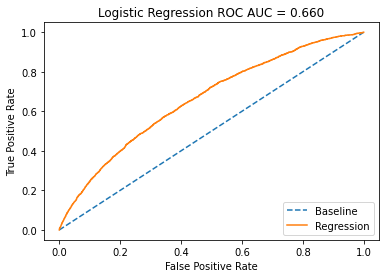

f1_score: 0.023
accuracy_score: 0.872
precision_score: 0.42
recall_score: 0.012
log_loss: 4.436
roc_auc_score: 0.66
average_precision_score: 0.131
brier_score_loss: 0.128
Confusion matrix:
[[19182    47]
 [ 2785    34]]


In [19]:
# have a look at first scores in naive model
scores(Y_test, y_pred, proba)

### EDA
### Numerical data

#### Look at the outliers of numerical columns

In [20]:
# prepare all IQR to find columns with outliers
al = []
for col in num_cols:
    al.append(iqr(data, col))
    
# find columns with outliers => yes in outlier column
all_borders = pd.DataFrame(al, columns=['IQR', 'perc25', 'perc75', 'lb', 'hb', 'max_v', 'min_v', 'data'])
all_borders = round(all_borders,3)
all_borders['outlier'] = 'yes'
all_borders.loc[(all_borders.hb >= all_borders.max_v) & (
    all_borders.lb <= all_borders.min_v), 'outlier'] = 'no'
all_borders

,IQR,perc25,perc75,lb,hb,max_v,min_v,data,outlier
0,18.000,30.00,48.000,3.000,75.000,72.0,21.000,age,no
1,0.000,0.00,0.000,0.000,0.000,33.0,0.000,decline_app_cnt,yes
2,28000.000,20000.00,48000.000,-22000.000,90000.000,1000000.0,1000.000,income,yes
3,3.000,0.00,3.000,-4.500,7.500,53.0,0.000,bki_request_cnt,yes
4,0.693,-2.26,-1.568,-3.299,-0.529,0.2,-3.625,score_bki,yes
5,10.000,50.00,60.000,35.000,75.000,80.0,20.000,region_rating,yes


##### It seems that all numerical columns accept 'age' have outliers - will look at them deeply
I haven't looked at categorical columns, think that there's no way of any outlier detection in that type, only in numerical type of data

#### Look at the boxplots of train numerical data

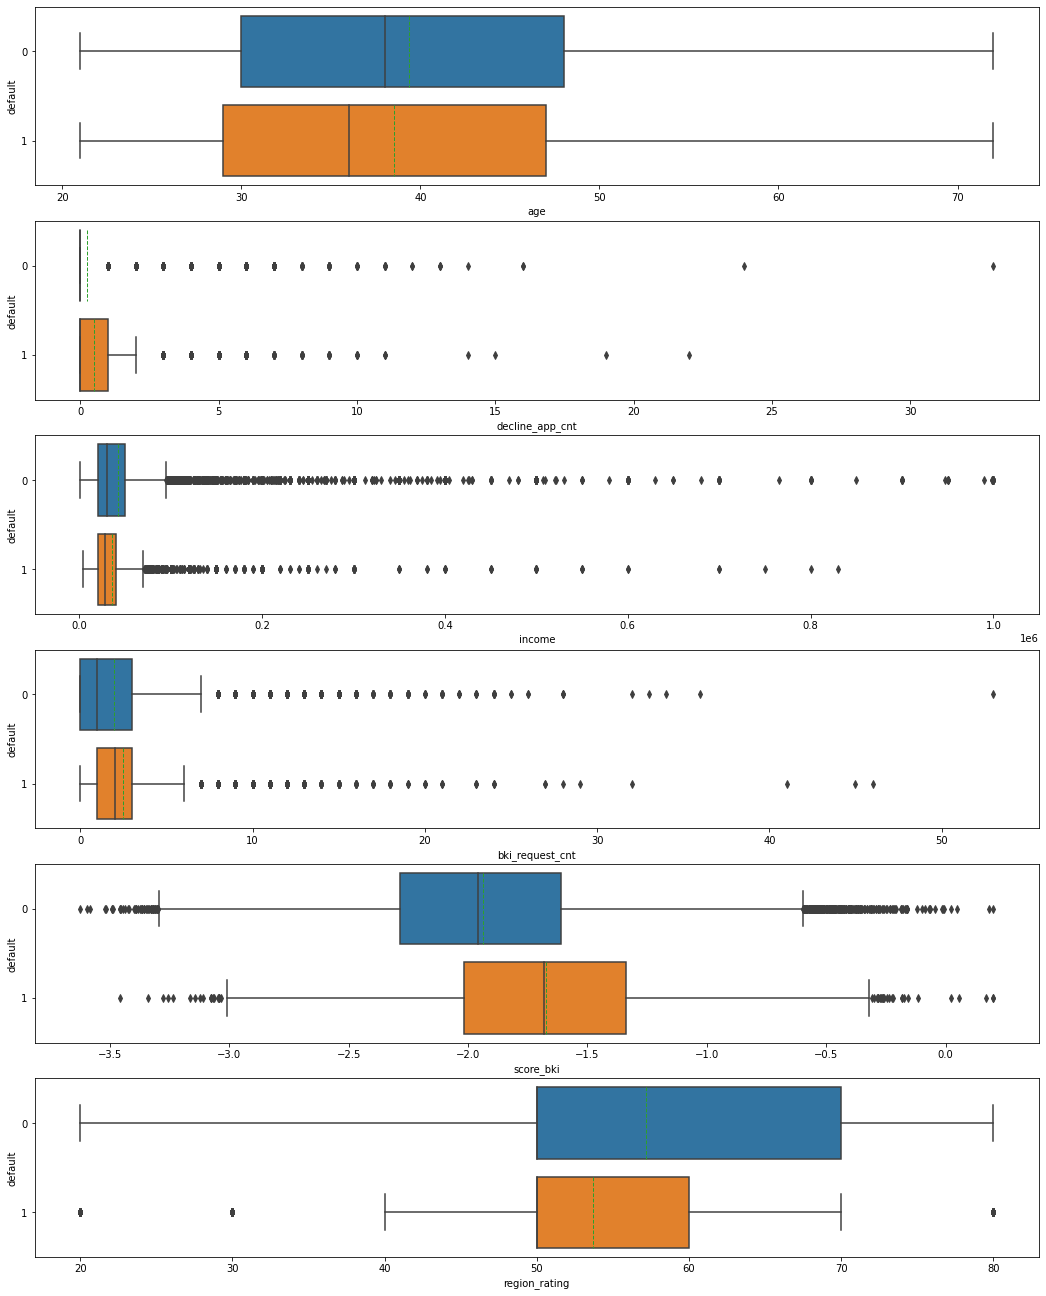

In [21]:
fig, axes = plt.subplots(6, 1, figsize=(18,23))
for i, column in enumerate(num_cols):
    sns.boxplot(x=data.query('sample == 1')[column],
                y=data.query('sample == 1')['default'],
                ax=axes.flat[i],
                showmeans=True,
                meanline=True,
                orient='h')

According to the boxplots default clients are: 
* younger,
* have higher mean\median number of declined applications, 
* have lower mean income,
* have higher mean\median number of bki requests,
* have higher mean\median score_bki
* have lower mean\median region_rating


#### Make columns with tail normally distributed
According to the pandas profiling report we need to make numerical data normally distributed

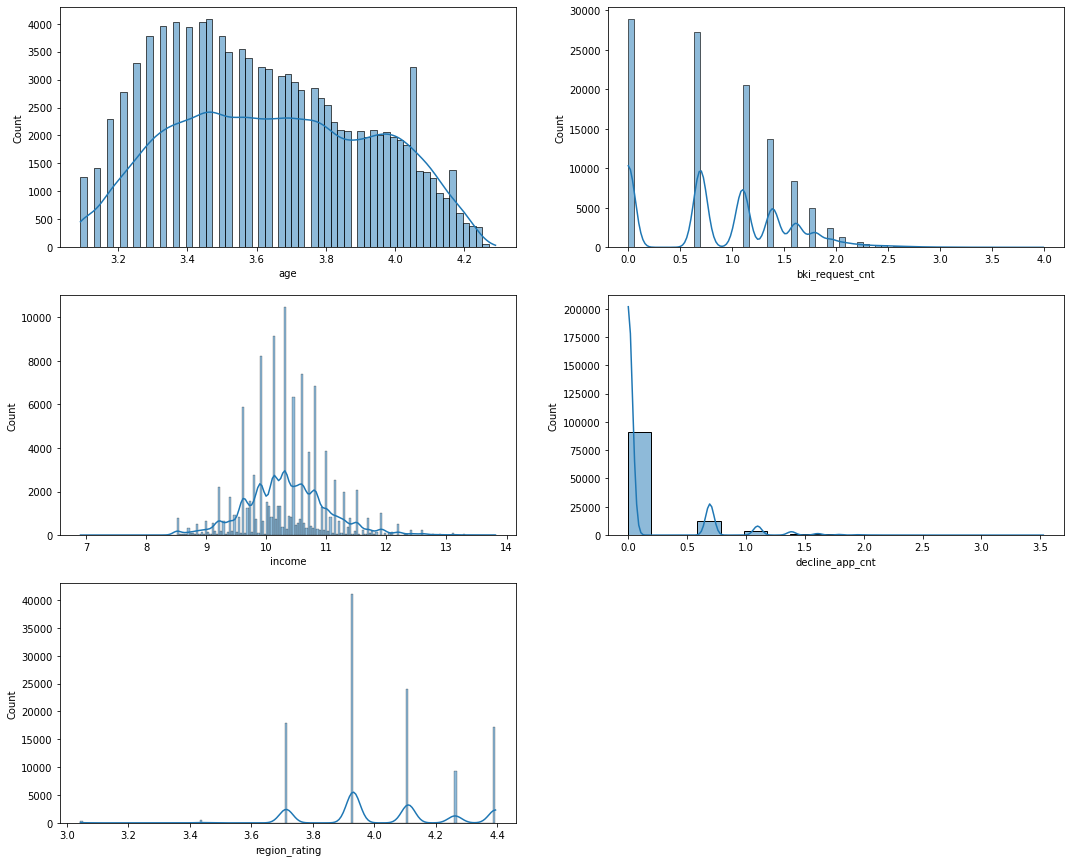

In [22]:
# log columns
tail_col = ['age', 'bki_request_cnt', 'income', 'decline_app_cnt', 'region_rating']
for col in tail_col:
    data[col] = np.log(data[col]+1)
    
# look at the result 
fig=plt.figure(figsize=(18, 15))
columns = 2
rows = 3
for i,col in enumerate(tail_col):
    fig.add_subplot(rows, columns, i+1)
    sns.histplot(data[col], kde=True)

#### decline_app_cnt

25-й перцентиль: 0.0, median: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
max value = 3.5263605246161616
min value = 0.0



[0.0, 0.0]

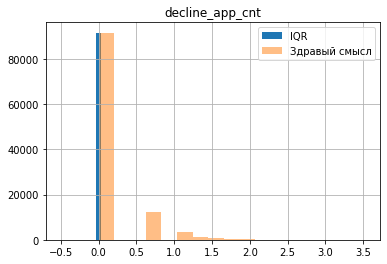

In [23]:
# look at the outliers deeper
col_name = 'decline_app_cnt'
hist_check(data[col_name], tit = col_name, rhb = 4)

<AxesSubplot:>

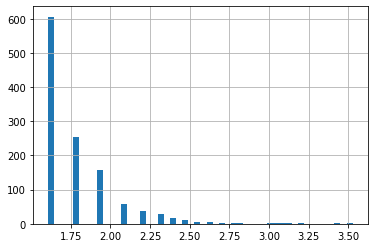

In [24]:
data.query('decline_app_cnt >1.5')['decline_app_cnt'].hist(bins =50)

According to the data values more than 1 don't seem like outliers, will leave them untouched and create new categorical column low\medium\high number of decline_app_cnt


In [25]:
# create new categorical column
bins = [-np.inf, 0, 0.5, 1, 1.75, np.inf]
labels=[0,1,2,3,4]
data['decline_app_cnt_cat'] = pd.cut(data['decline_app_cnt'], bins=bins, labels=labels)

#### income

25-й перцентиль: 9.90353755128617, median: 10.308985993422082, 75-й перцентиль: 10.778977123006351, IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
max value = 13.815511557963774
min value = 6.90875477931522



[8.590378193705899, 12.092136480586621]

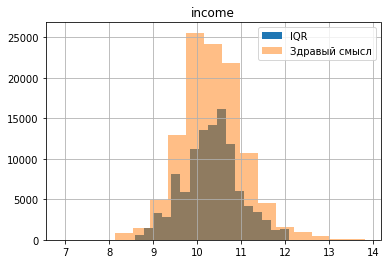

In [26]:
# look at the outliers deeper
col_name = 'income'
hist_check(data[col_name], tit = col_name, rhb = 14)

The data looks good, will add new categorical column with low\medium\high income

In [27]:
# create new categorical column
bins = [0, 9.9, 10.30895, 10.77897, np.inf]
labels=[0,1,2,3]
data['income_cat'] = pd.cut(data['income'], bins=bins, labels=labels)

#### bki_request_cnt

25-й перцентиль: 0.0, median: 0.6931471805599453, 75-й перцентиль: 1.3862943611198906, IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
max value = 3.9889840465642745
min value = 0.0



[-2.0794415416798357, 3.465735902799726]

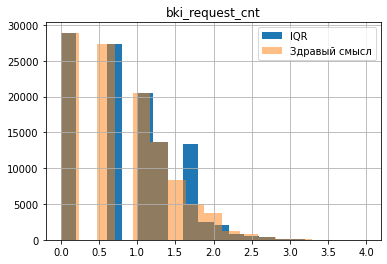

In [28]:
# look at the outliers deeper
col_name = 'bki_request_cnt'
hist_check(data[col_name], tit = col_name, rhb = 14)

<AxesSubplot:>

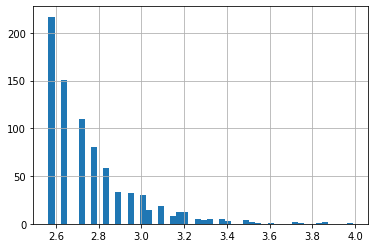

In [29]:
data.query('bki_request_cnt >2.5')['bki_request_cnt'].hist(bins =50)

The data has just a few outliers, seems ok, will leave untouched

#### score_bki

25-й перцентиль: -2.2604336700000003, median: -1.92082293, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
max value = 0.19977285
min value = -3.62458632



[-3.299251946250001, -0.5290698762499992]

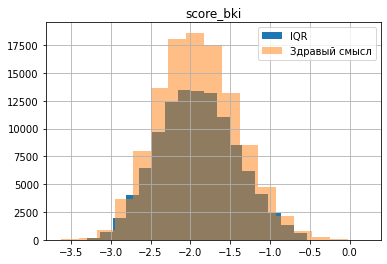

In [30]:
# look at the outliers deeper
col_name = 'score_bki'
hist_check(data[col_name], tit = col_name, rhb = 14)

The data has just a few outliers, seems ok, will leave untouched

#### region_rating

25-й перцентиль: 3.9318256327243257, median: 3.9318256327243257, 75-й перцентиль: 4.110873864173311, IQR: 0.17904823144898563,  Границы выбросов: [3.663253285550847, 4.37944621134679].
max value = 4.394449154672439
min value = 3.044522437723423



[3.663253285550847, 4.37944621134679]

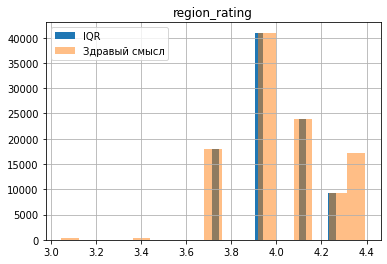

In [31]:
# look at the outliers deeper
col_name = 'region_rating'
hist_check(data[col_name], tit = col_name, rhb = 14)

The data has some outliers, but as we don't know what does the column mean - will leave it untouched & add one more categorical column.

In [32]:
# create new categorical column
bins = [0, 3.6, 3.93182564, 4.111, np.inf]
labels=[0,1,2,3]
data['region_rating_cat'] = pd.cut(data['region_rating'], bins=bins, labels=labels)

### Categorical data

#### app_date

In [33]:
# make needed format
data['app_date'] = pd.to_datetime(data['app_date'])
# check the data
data['app_date'].value_counts()

2014-03-18    1491
2014-03-19    1363
2014-03-17    1350
2014-03-31    1317
2014-04-07    1296
              ... 
2014-04-20     359
2014-01-07     349
2014-01-03     313
2014-01-02     204
2014-01-01      56
Name: app_date, Length: 120, dtype: int64

In [34]:
# check unique dates
print(f"{data['app_date'].dt.year.unique()}\n{data['app_date'].dt.month_name().unique()}\
    \n{sorted(data['app_date'].dt.day.unique())}")

[2014]
['March' 'January' 'February' 'April']    
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


There is only 4 unique month

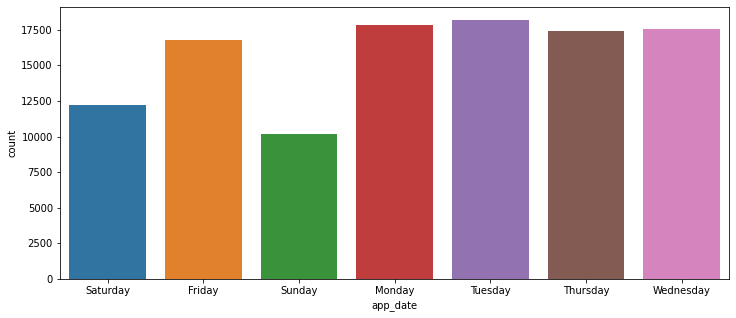

In [35]:
# look at the days of week
fig = plt.subplots(figsize=(12, 5))
sns.countplot(x=data['app_date'].dt.day_name());

There are ~ equal number of requests at working days & lower number at the weekends

In [36]:
# add categorical column with day of week 
days = dict(zip(data['app_date'].dt.day_name().sort_values().unique(), range(len(data['app_date'].dt.day_name())+1)))
data['app_day'] = data['app_date'].dt.day_name().map(days)
data['app_day'].unique()

array([2, 0, 3, 1, 5, 4, 6])

In [37]:
# add categorical column with month
months = dict(zip(data['app_date'].dt.month_name().sort_values().unique(), range(len(data['app_date'].dt.month_name())+1)))
data['app_month'] = data['app_date'].dt.month_name().map(months)
data['app_month'].unique()

array([3, 2, 1, 0])

In [38]:
# add numerical column with time from app_date
td = pd.to_datetime("today")
data['time'] = (td - data['app_date']).dt.days.values.reshape(-1, 1)
# add column with difference of the first day with rest
data['min_time_dif'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days) 

#### education

In [39]:
# replace nan's with the most common
data['education'].fillna(data['education'].mode()[0], inplace=True)

In [40]:
data['education'] = data['education'].astype('int8')
data['education'].unique()

array([1, 3, 4, 2, 0], dtype=int8)

### Create new columns

In [41]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,decline_app_cnt_cat,income_cat,region_rating_cat,app_day,app_month,time,min_time_dif
0,74835,2014-03-22,1,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,3.931826,1,2,10.819798,1,4,0,0,0,0,3,1,2,3,2723,80
1,17527,2014-01-24,3,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,3.931826,1,2,8.517393,4,3,0,0,0,4,0,1,0,2,2780,23
2,75683,2014-03-23,4,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,3.931826,1,2,10.308986,1,3,1,0,0,0,2,1,3,3,2722,81
3,26883,2014-02-03,3,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,3.713572,1,2,9.741027,1,3,0,0,0,0,0,1,1,1,2770,33
4,28862,2014-02-04,1,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,4.394449,2,3,11.695255,1,3,0,0,0,0,3,3,5,1,2769,34


<AxesSubplot:xlabel='education', ylabel='income'>

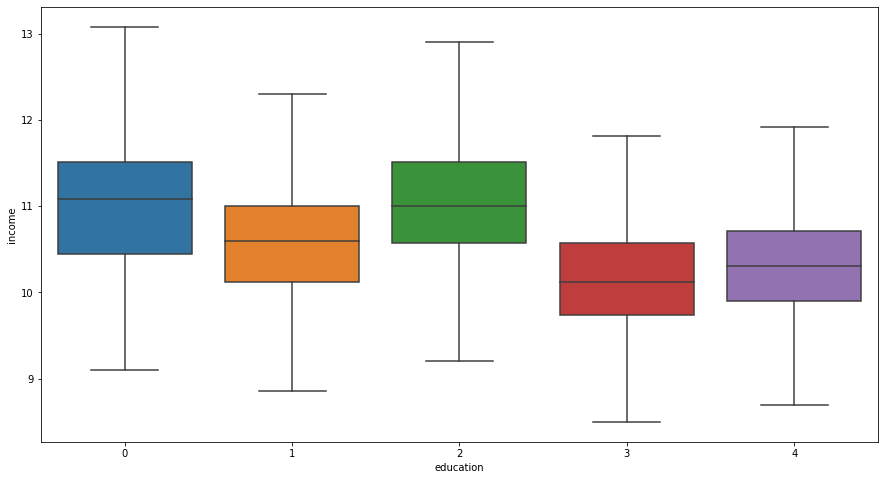

In [42]:
# suppose that income depends on education, check it
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=data, showfliers=False)

education 3,4 have lower median income

In [43]:
# add column of dependency education & income
data['ed_inc'] = data['education'] * data['income']

In [44]:
# as we know from pandas profiling report 'car_type' correlates with 'car'
data['car_ct'] = data['car'] + data['car_type']
data.car_ct.unique()

array([2, 0, 1])

In [45]:
# multiply work and home address 
data['mult_address'] = data['home_address'] * data['work_address']

In [46]:
# get mean income by age & normalize income by age mean
data['mean_income_age'] = data.groupby('age')['income'].transform('mean')
data['norm_inc_age'] = data.income / data.mean_income_age

In [47]:
# get mean income by region raiting 
data['reg_rat_mean_inc'] = data.groupby('region_rating')['income'].transform('mean')

<AxesSubplot:xlabel='work_address', ylabel='income'>

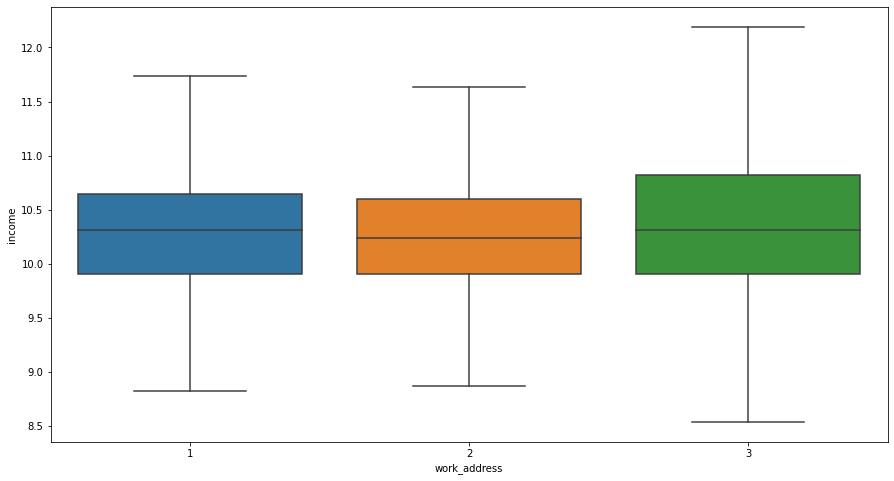

In [48]:
# suppose that income depends on work address, check it
plt.figure(figsize=(15, 8))
sns.boxplot(x="work_address", y="income", data=data, showfliers=False)

I don't see the correlation

<AxesSubplot:xlabel='first_time', ylabel='sna'>

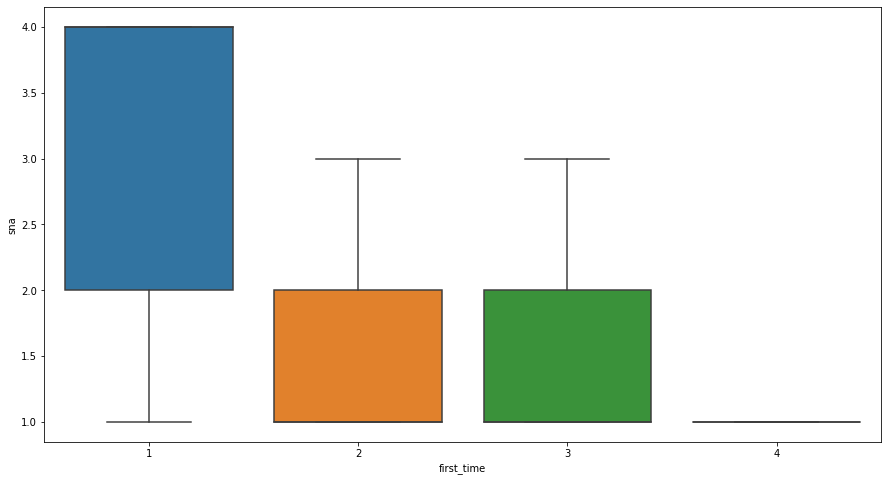

In [49]:
# check the first_time & sna correlation
plt.figure(figsize=(15, 8))
sns.boxplot(x="first_time", y="sna", data=data, showfliers=False)

<AxesSubplot:xlabel='work_address', ylabel='region_rating'>

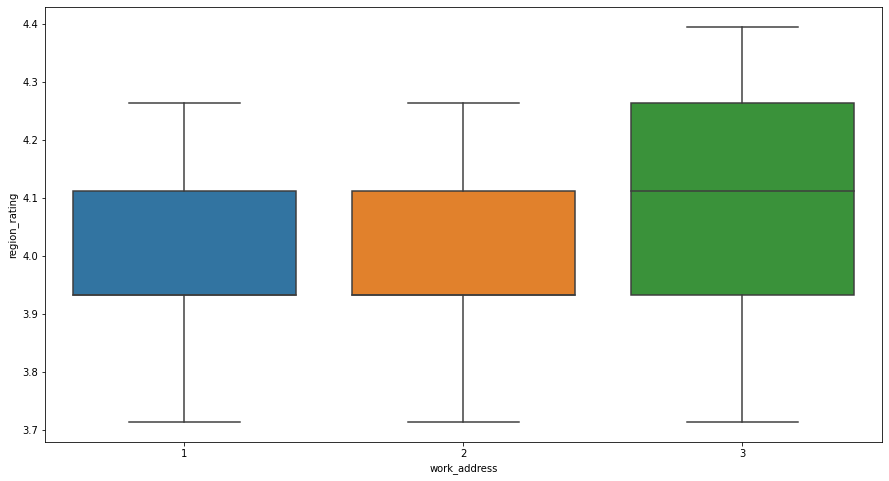

In [50]:
plt.figure(figsize=(15, 8))
sns.boxplot(y="region_rating", x="work_address", data=data, showfliers=False)

In [51]:
# prepare new features from some correlated columns
data['dec_ap_score_reg'] = data['decline_app_cnt'] * data['score_bki']/data['region_rating']
data['dec_ap_bki_req_reg'] = data['decline_app_cnt'] * data['bki_request_cnt']/data['region_rating']
data['score_bki_req_reg'] = data['score_bki'] * data['bki_request_cnt']/data['region_rating']
data['reg_rat_inc'] = data['income'] / data['region_rating']
data['sna_first_reg'] = data['sna'] * data['first_time']/data['region_rating']
data['mean_req_age'] = data.groupby('age')['bki_request_cnt'].transform('mean')
data['mean_requests_income'] = data.groupby('income')['bki_request_cnt'].transform('mean')
data['mean_bki_age'] = data.groupby('age')['bki_request_cnt'].transform('mean')
data['bki_age_reg'] = (data['score_bki']/data['age'])*data['region_rating']

In [52]:
# it isn't better than mult_address

# # get one column from address columns using PCA
# data_addresses = data[['work_address', 'home_address']].values
# 
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data_addresses)
# 
# pca = PCA(n_components=1)
# pca.fit(scaled_data)
# pca_data = pca.transform(scaled_data)
# data['pca_address'] = pca_data
# 
# data['pca_address'].hist()

In [53]:
# it isn't better than car_ct

# # get one column from car columns using PCA
# car_data = data[['car', 'car_type']].values
# 
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(car_data)
# 
# pca = PCA(n_components=1)
# pca.fit(scaled_data)
# pca_data = pca.transform(scaled_data)
# data['pca_car'] = pca_data
# 
# data['pca_car'].hist()

##### Question
Is it better ro apply PCA to highly correlated columns at first or just multiply them and apply PCA at whole dataset?

In [54]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample',
       'decline_app_cnt_cat', 'income_cat', 'region_rating_cat', 'app_day',
       'app_month', 'time', 'min_time_dif', 'ed_inc', 'car_ct', 'mult_address',
       'mean_income_age', 'norm_inc_age', 'reg_rat_mean_inc',
       'dec_ap_score_reg', 'dec_ap_bki_req_reg', 'score_bki_req_reg',
       'reg_rat_inc', 'sna_first_reg', 'mean_req_age', 'mean_requests_income',
       'mean_bki_age', 'bki_age_reg'],
      dtype='object')

In [55]:
# remove highly correlated columns
data.drop(['home_address','work_address'], axis=1, inplace=True)
data.drop(['car','car_type'], axis=1, inplace=True)

In [56]:
# update columns
#binary variables
bin_cols=['sex','good_work','foreign_passport']

#categorical variables
cat_cols=['education','sna', 'first_time', 'decline_app_cnt_cat', 'income_cat',\
          'region_rating_cat', 'app_day', 'app_month', 'car_ct', 'mult_address'] 

#numerical variables
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating', 'time', 'min_time_dif',\
          'ed_inc', 'mean_income_age', 'norm_inc_age', 'reg_rat_mean_inc', 'dec_ap_score_reg', 'dec_ap_bki_req_reg',\
          'score_bki_req_reg', 'reg_rat_inc', 'sna_first_reg', 'mean_req_age', 'mean_requests_income', 'mean_bki_age',\
         'bki_age_reg']

In [57]:
list(set(data.columns) - set(bin_cols+cat_cols+num_cols))

['sample', 'default', 'client_id', 'app_date']

#### Standartize numerical data

In [58]:
data.head()
data_num_sc = data.copy()

In [59]:
# scale only numeric columns for future
data_num_sc[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data_num_sc[num_cols].values), \
                                     columns = data_num_sc[num_cols].columns)

#### Look at the useful columns

##### Numerical

<AxesSubplot:>

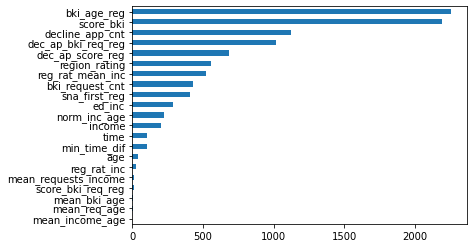

In [60]:
imp_num = pd.Series(f_classif(data_num_sc[num_cols], data_num_sc['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Mean_income_age, mean_req_age & mean_bki_age are the most useless numerical columns. reg_rat_inc, score_bki_req_reg & mean_requests_income also have low significance

##### Categorical & Binary

<AxesSubplot:>

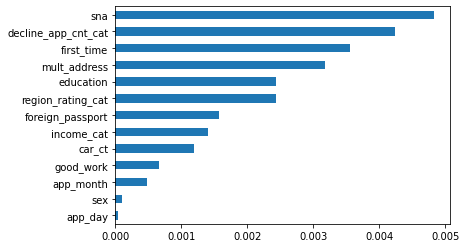

In [61]:
imp_cat = Series(mutual_info_classif(data_num_sc[bin_cols + cat_cols], data_num_sc['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

app_day is the most useless categorical column.



### Look at the feature correlation

<AxesSubplot:>

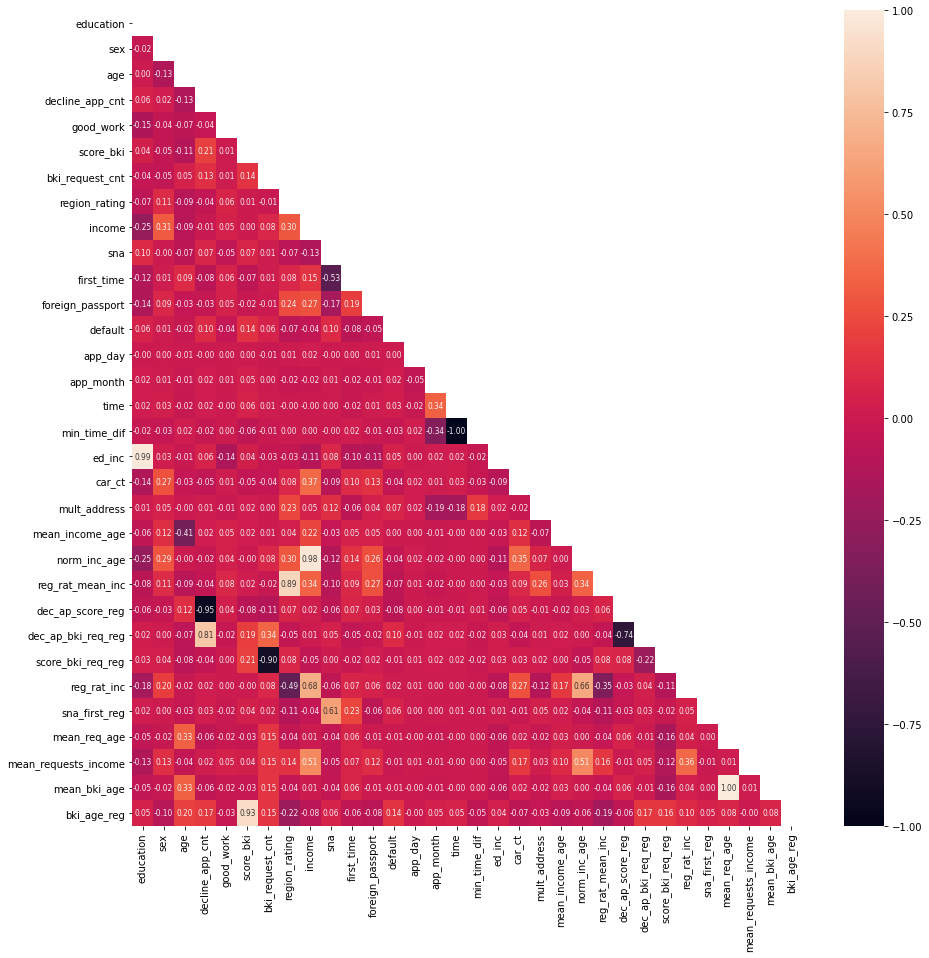

In [62]:
fig, ax = plt.subplots(figsize=(15,15))      
matrix = np.triu(data_num_sc.drop(['client_id', 'app_date','sample'], axis=1).corr())
sns.heatmap(data_num_sc.drop(['client_id', 'app_date','sample'], axis=1).corr(), \
            annot=True, mask=matrix, fmt = '.2f', annot_kws={"size": 7.5, "alpha" : 0.9})

In [63]:
# remove highly correlated columns
data_num_sc.drop(['time', 'dec_ap_score_reg', 'dec_ap_bki_req_reg', 'ed_inc', 'bki_age_reg', 'mean_bki_age',\
                 'score_bki_req_reg', 'norm_inc_age','reg_rat_mean_inc'], axis = 1, inplace = True)

Removing highly correlated columns leads to a little bit lower roc_auc_score & f1_score - why it could be? Columns with lower or equal correlation with default column were removed.

#### Check the model without dummy variables

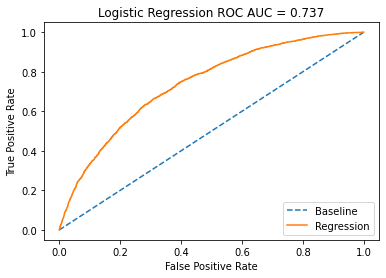

f1_score: 0.341
accuracy_score: 0.67
precision_score: 0.228
recall_score: 0.679
log_loss: 11.382
roc_auc_score: 0.737
average_precision_score: 0.195
brier_score_loss: 0.33
Confusion matrix:
[[12955  6405]
 [  891  1889]]


In [64]:
train = data_num_sc.copy().query('sample == 1').drop(['client_id', 'app_date','sample'], axis=1)
X = train.drop(['default'], axis = 1)
y = train['default']
# split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
# run the model & predict data and probability of 1 
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced').fit(X_train, Y_train)
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]
# have a look at scores 
scores(Y_test, y_pred, proba)

In comparison with initial model we get more TN and less TP values. So the model think that much more people are default clients who are not in real life. At the same time the model predict much more really default clients.

#### Encode categorical data

In [65]:
data_all_num = pd.get_dummies(data_num_sc, columns=cat_cols)

In [66]:
data_all_num.describe()

,client_id,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,foreign_passport,default,sample,min_time_dif,mean_income_age,reg_rat_inc,sna_first_reg,mean_req_age,mean_requests_income,education_0,education_1,education_2,education_3,education_4,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,decline_app_cnt_cat_0,decline_app_cnt_cat_1,decline_app_cnt_cat_2,decline_app_cnt_cat_3,decline_app_cnt_cat_4,income_cat_0,income_cat_1,income_cat_2,income_cat_3,region_rating_cat_0,region_rating_cat_1,region_rating_cat_2,region_rating_cat_3,app_day_0,app_day_1,app_day_2,app_day_3,app_day_4,app_day_5,app_day_6,app_month_0,app_month_1,app_month_2,app_month_3,car_ct_0,car_ct_1,car_ct_2,mult_address_1,mult_address_2,mult_address_3,mult_address_4,mult_address_6,mult_address_9
count,110148.000000,110148.000000,1.101480e+05,1.101480e+05,110148.000000,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,110148.000000,110148.000000,110148.000000,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.0,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,0.438610,-8.111700e-16,-2.919997e-15,0.165514,-5.249928e-16,8.285095e-16,2.731741e-15,9.153816e-16,0.149136,0.085086,0.669999,-2.728729e-16,-7.349846e-15,-1.096136e-15,-1.098222e-15,-8.919541e-16,-1.010895e-15,0.002642,0.315648,0.016932,0.530886,0.133893,0.641691,0.143734,0.055870,0.158705,0.166104,0.156580,0.422958,0.254358,0.830437,0.0,0.113484,0.050777,0.005302,0.216082,0.232442,0.300659,0.250817,0.006782,0.534989,0.217880,0.240349,0.152059,0.162127,0.110778,0.092212,0.158160,0.165051,0.159613,0.238461,0.246005,0.228674,0.286859,0.674456,0.134819,0.190725,0.107419,0.267585,0.071032,0.014290,0.524113,0.015561
std,31797.133063,0.496219,1.000005e+00,1.000005e+00,0.371645,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.356224,0.279010,0.470215,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.051332,0.464776,0.129016,0.499047,0.340538,0.479506,0.350821,0.229672,0.365402,0.372175,0.363406,0.494031,0.435502,0.375250,0.0,0.317185,0.219543,0.072622,0.411573,0.422391,0.458547,0.433485,0.082072,0.498777,0.412807,0.427298,0.359080,0.368569,0.313859,0.289327,0.364893,0.371228,0.366248,0.426144,0.430684,0.419981,0.452297,0.468580,0.341531,0.392875,0.309647,0.442702,0.256879,0.118684,0.499420,0.123769
min,1.000000,0.000000,-1.976836e+00,-4.188152e-01,0.000000,-3.444269e+00,-1.334144e+00,-4.377794e+00,-4.933787e+00,0.000000,0.000000,0.000000,-1.900848e+00,-5.012549e+00,-4.629529e+00,-1.324634e+00,-8.831324e+00,-8.718199e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27537.750000,0.000000,-7.737452e-01,-4.188152e-01,0.000000,-7.126592e-01,-1.334144e+00,-4.395310e-01,-6.348458e-01,0.000000,0.000000,0.000000,-8.720390e-01,-2.640815e-01,-6.560556e-01,-5.094615e-01,-1.100558e-01,-3.397896e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.0

In [67]:
# drop not needed columns, filter only initial train data
train = data_all_num.copy().query('sample == 1').drop(['client_id', 'app_date','sample'], axis=1)
X = train.drop(['default'], axis = 1)
y = train['default']
# split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [68]:
# run the model & predict data and probability of 1 
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced').fit(X_train, Y_train)
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

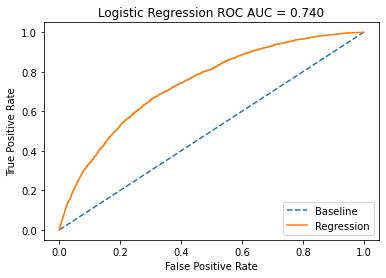

f1_score: 0.344
accuracy_score: 0.671
precision_score: 0.229
recall_score: 0.685
log_loss: 11.346
roc_auc_score: 0.74
average_precision_score: 0.197
brier_score_loss: 0.329
Confusion matrix:
[[12963  6397]
 [  876  1904]]


In [69]:
# have a look at scores
scores(Y_test, y_pred, proba)

It's good roc_auc, but not enough f1 & precision and too high log_loss 

### Try PCA

In order to decrease feature number

In [70]:
X_train.shape[1]

61

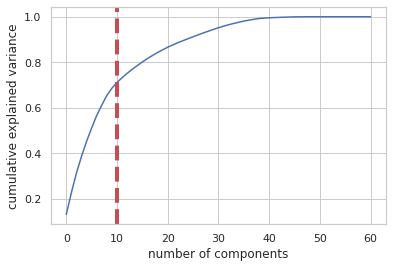

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.130898,0.130898
1,0.226190,0.095292
2,0.312404,0.086214
3,0.386120,0.073716
4,0.452269,0.066150
5,0.511163,0.058894
6,0.566033,0.054870
7,0.611606,0.045573
8,0.654142,0.042536
9,0.686044,0.031901


In [71]:
# look at the pca of all variables to select the threshold
from sklearn.decomposition import PCA
pca_test = PCA(n_components=X_train.shape[1])
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))


In [72]:
# calculate number of components which have 0.9999 cumulative variance ratio
select_n_components(evr, 0.9999)

49

In [73]:
pca = PCA(n_components=49)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

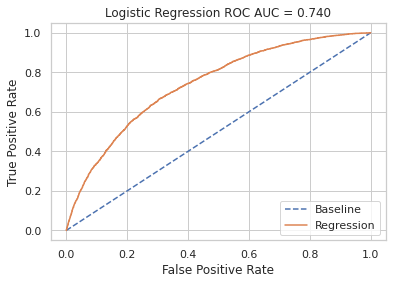

f1_score: 0.344
accuracy_score: 0.672
precision_score: 0.23
recall_score: 0.685
log_loss: 11.342
roc_auc_score: 0.74
average_precision_score: 0.197
brier_score_loss: 0.328
Confusion matrix:
[[12965  6395]
 [  875  1905]]


In [74]:
# run the model & predict data and probability of 1  with PCA
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced').\
    fit(X_train_pca, Y_train)
y_pred_pca = model.predict(X_test_pca)
proba = model.predict_proba(X_test_pca)[:, 1]
# have a look at scores 
scores(Y_test, y_pred_pca, proba)

In [75]:
# try pca at whole dataset
pca = PCA(n_components=49)
pca.fit(X)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

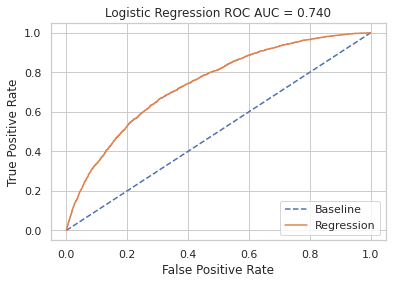

f1_score: 0.344
accuracy_score: 0.672
precision_score: 0.229
recall_score: 0.685
log_loss: 11.343
roc_auc_score: 0.74
average_precision_score: 0.197
brier_score_loss: 0.328
Confusion matrix:
[[12964  6396]
 [  875  1905]]


In [76]:
# run the model & predict data and probability of 1  with PCA
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced').\
    fit(X_train_pca, Y_train)
y_pred_pca = model.predict(X_test_pca)
proba = model.predict_proba(X_test_pca)[:, 1]
# have a look at scores 
scores(Y_test, y_pred_pca, proba)

It didn't make the scores better

#### Try SVD

In [77]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=X.shape[1]-1)
X_tsvd = tsvd.fit(X)

# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

# calculate number of components which have 0.9999 cumulative variance ratio
select_n_components(tsvd_var_ratios, 0.9999)

50

In [78]:
svd = TruncatedSVD(n_components = 50).fit(X)

X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

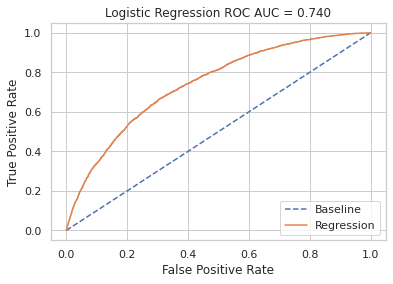

f1_score: 0.344
accuracy_score: 0.672
precision_score: 0.23
recall_score: 0.685
log_loss: 11.34
roc_auc_score: 0.74
average_precision_score: 0.197
brier_score_loss: 0.328
Confusion matrix:
[[12966  6394]
 [  875  1905]]


In [79]:
# run the model & predict data and probability of 1  with SVD
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced').\
    fit(X_train_svd, Y_train)

y_pred_svd = model.predict(X_test_svd)
proba = model.predict_proba(X_test_svd)[:, 1]
# have a look at scores 
scores(Y_test, y_pred_svd, proba)

In general it seems that PCA & SVD just decreased number of features. According to the scores and confusion matrix it seems that SVD is a little bit better, will use it

### Try different hyperparameters 

	C: 2.7825594022071245
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 30
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False


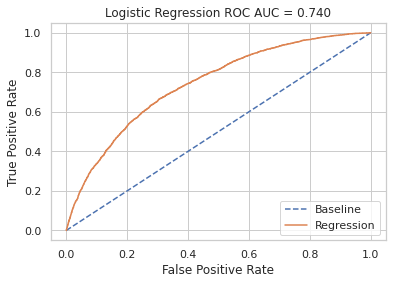

f1_score: 0.344
accuracy_score: 0.671
precision_score: 0.23
recall_score: 0.686
log_loss: 11.346
roc_auc_score: 0.74
average_precision_score: 0.197
brier_score_loss: 0.329
Confusion matrix:
[[12960  6400]
 [  873  1907]]


In [80]:
iter_ = 30
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'C': np.logspace(0, 4, 10),
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'C': np.logspace(0, 4, 10),
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': np.logspace(0, 4, 10),
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train_svd, Y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds_svd = model.predict(X_test_svd)
proba = model.predict_proba(X_test_svd)[:, 1]
scores(Y_test, preds_svd, proba)

It seems that trying different hyperparameters didn't help to improve the model

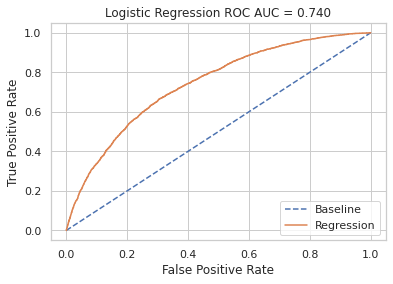

f1_score: 0.344
accuracy_score: 0.671
precision_score: 0.23
recall_score: 0.686
log_loss: 11.346
roc_auc_score: 0.74
average_precision_score: 0.197
brier_score_loss: 0.329
Confusion matrix:
[[12960  6400]
 [  873  1907]]


In [81]:
# run the model & predict data and probability of 1 
model = LogisticRegression(solver='newton-cg', C=2.7825594, class_weight = 'balanced', max_iter=1000, random_state=RANDOM_SEED, \
                          dual = False, fit_intercept = True, penalty = 'l2', intercept_scaling = 1, \
                          l1_ratio = None, multi_class = 'auto', n_jobs = None, tol = 0.001, warm_start = False, \
                          verbose = 0).fit(X_train_svd, Y_train)
y_pred_svd = model.predict(X_test_svd)
proba = model.predict_proba(X_test_svd)[:, 1]
# have a look at scores 
scores(Y_test, y_pred_svd, proba)

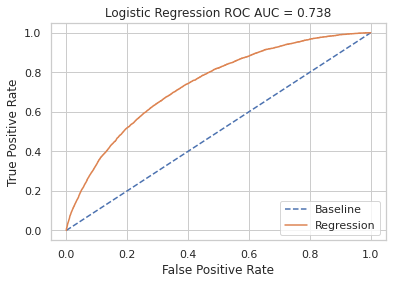

f1_score: 0.345
accuracy_score: 0.673
precision_score: 0.232
recall_score: 0.673
log_loss: 11.284
roc_auc_score: 0.738
average_precision_score: 0.198
brier_score_loss: 0.327
Confusion matrix:
[[30343 14724]
 [ 2153  4439]]


In [82]:
# just to compare train and test model prediction scores
y_pred_train = model.predict(X_train_svd)
proba_train = model.predict_proba(X_train_svd)[:, 1]
scores(Y_train, y_pred_train, proba_train)

### Submission

In [83]:
# select test data
prediction = data_all_num.copy().query('sample == 0')

# remove unnecessary columns
test = prediction.drop(['client_id', 'app_date','sample', 'default'], axis=1)

# reduce number of features using svd model
svd_test = svd.transform(test)

# predict the data & prepare the submission file
y_pred_final = model.predict_proba(svd_test)[:, 1]
submission = pd.concat([prediction.client_id,pd.Series(y_pred_final,name='default')],axis=1)
submission.to_csv('submission.csv', index=False)

In [84]:
submission

,client_id,default
0,74835,0.193865
1,17527,0.733678
2,75683,0.321053
3,26883,0.421345
4,28862,0.143958
...,...,...
36344,83775,0.800750
36345,106254,0.095978
36346,81852,0.782822
36347,1971,0.700843


To tell the truth I think I tried everything to increse roc_auc & f1 score, I will be grateful if you write what else I could do.